CUDA Available: True
Device Name: Tesla T4
Cloning into 'rfml'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 260 (delta 8), reused 4 (delta 4), pack-reused 238 (from 2)
Receiving objects: 100% (260/260), 17.47 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/rfml
Obtaining file:///content/rfml
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.7 MB/s eta 0:00:00
  Created wheel for setGPU: filename=setGPU-0.0.7-py3-none-any.whl size=1520 sha256=8e7a7c345811dc588f5e7b6b09e043c3e9b93da683b0fbf5e0d9c987a29473da
  Stored in directory: /root/.cache/pip/wheels/52/79

Epoch 1/10 | Train Acc: 22.88% | Val Acc: 31.46%


Epoch 2/10 | Train Acc: 35.91% | Val Acc: 37.08%


Epoch 3/10 | Train Acc: 39.53% | Val Acc: 40.11%


Epoch 4/10 | Train Acc: 42.43% | Val Acc: 42.33%


Epoch 5/10 | Train Acc: 44.12% | Val Acc: 43.80%


Epoch 6/10 | Train Acc: 44.78% | Val Acc: 43.42%


Epoch 7/10 | Train Acc: 45.51% | Val Acc: 44.14%


Epoch 8/10 | Train Acc: 46.27% | Val Acc: 44.04%


Epoch 9/10 | Train Acc: 46.53% | Val Acc: 45.76%


Epoch 10/10 | Train Acc: 47.06% | Val Acc: 46.12%

 Training Transformer (2 Layer(s))


Epoch 1/10 | Train Acc: 23.45% | Val Acc: 32.07%


Epoch 2/10 | Train Acc: 37.59% | Val Acc: 39.63%


Epoch 3/10 | Train Acc: 42.31% | Val Acc: 43.43%


Epoch 4/10 | Train Acc: 44.72% | Val Acc: 45.14%


Epoch 5/10 | Train Acc: 46.16% | Val Acc: 46.32%


Epoch 6/10 | Train Acc: 47.08% | Val Acc: 47.11%


Epoch 7/10 | Train Acc: 47.85% | Val Acc: 47.76%


Epoch 8/10 | Train Acc: 48.47% | Val Acc: 47.74%


Epoch 9/10 | Train Acc: 48.96% | Val Acc: 48.28%


Epoch 10/10 | Train Acc: 49.32% | Val Acc: 49.25%

 Training Transformer (3 Layer(s))


Epoch 1/10 | Train Acc: 25.01% | Val Acc: 37.55%


Epoch 2/10 | Train Acc: 40.62% | Val Acc: 42.92%


Epoch 3/10 | Train Acc: 44.82% | Val Acc: 45.42%


Epoch 4/10 | Train Acc: 47.13% | Val Acc: 47.34%


Epoch 5/10 | Train Acc: 48.10% | Val Acc: 47.99%


Epoch 6/10 | Train Acc: 48.83% | Val Acc: 48.13%


Epoch 7/10 | Train Acc: 49.04% | Val Acc: 49.16%


Epoch 8/10 | Train Acc: 49.73% | Val Acc: 49.49%


Epoch 9/10 | Train Acc: 49.96% | Val Acc: 49.71%


Epoch 10/10 | Train Acc: 50.50% | Val Acc: 50.01%


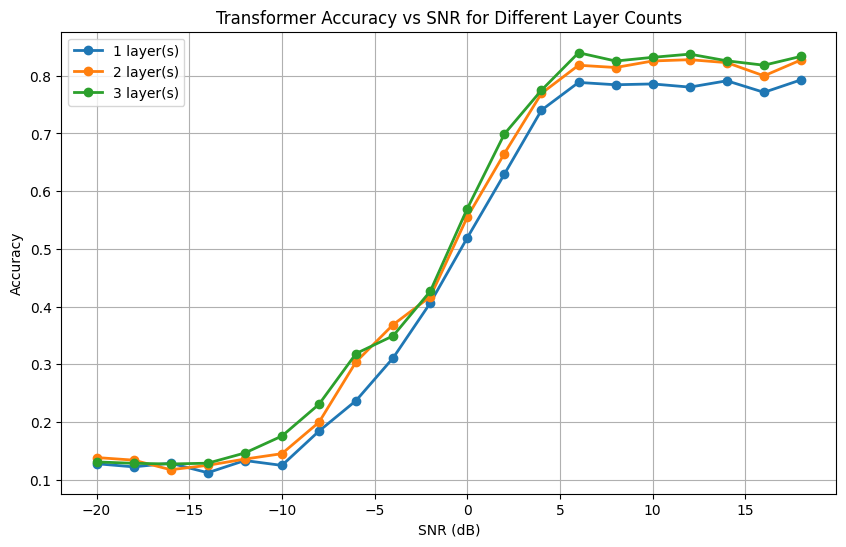

In [1]:
# ============================
# 📦 1. Setup & Imports
# ============================
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

!git clone https://github.com/brysef/rfml.git
%cd rfml
!pip install -e .
!pip install scikit-learn matplotlib tqdm
%cd ..

from google.colab import drive
drive.mount('/content/drive')

import pickle, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================
# 📊 2. Load Dataset
# ============================
dataset_path = "/content/drive/MyDrive/RF_dataset/RML2016.10a_dict.pkl"
with open(dataset_path, "rb") as f:
    Xd = pickle.load(f, encoding="latin1")

digital_mods = ['BPSK','QPSK','8PSK','QAM16','QAM64','PAM4','CPFSK','GFSK']
X_all, Y_all, snrs_all = [], [], []

for mod, snr in Xd.keys():
    if mod not in digital_mods:
        continue
    samples = Xd[(mod, snr)]
    for s in samples:
        X_all.append(s)
        Y_all.append(digital_mods.index(mod))
        snrs_all.append(snr)

X_all, Y_all, snrs_all = np.array(X_all), np.array(Y_all), np.array(snrs_all)
X_all = (X_all - np.mean(X_all, axis=-1, keepdims=True)) / (np.std(X_all, axis=-1, keepdims=True) + 1e-6)

print("Final dataset shape:", X_all.shape)
print("Unique classes:", np.unique(Y_all))

# ============================
# 🔀 3. Split Data
# ============================
X_train, X_temp, Y_train, Y_temp, snrs_train, snrs_temp = train_test_split(
    X_all, Y_all, snrs_all, test_size=0.33, stratify=Y_all, random_state=42)
val_ratio = 13/(13+20)
X_val, X_test, Y_val, Y_test, snrs_val, snrs_test = train_test_split(
    X_temp, Y_temp, snrs_temp, test_size=(1-val_ratio), stratify=Y_temp, random_state=42)

print("Shapes: Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ============================
# 🧩 4. Dataset & Dataloaders
# ============================
class RadioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

batch_size = 256  # reduce if CPU only
train_loader = DataLoader(RadioDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(RadioDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(RadioDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

# ============================
# 🧠 5. Transformer Definition
# ============================
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2], pe[:, 1::2] = torch.sin(position*div_term), torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class RFTransformer(nn.Module):
    def __init__(self, input_features=2, d_model=128, nhead=8, num_layers=3,
                 dim_feedforward=512, dropout=0.2, num_classes=8, max_len=128):
        super().__init__()
        self.input_proj = nn.Linear(input_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))

    def forward(self, x):
        x = x.permute(0,2,1)              # (B, seq_len, 2)
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        pooled = x.mean(dim=1)
        return self.classifier(pooled)

# ============================
# ⚙️ 6. Training Function
# ============================
def train_transformer(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=10):
    history = {"train_acc":[], "val_acc":[]}
    best_val = 0
    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            loss_sum += loss.item()*yb.size(0)
        train_acc = correct/total
        train_loss = loss_sum/total

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct/val_total
        scheduler.step(val_acc)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), f"best_transformer_{num_layers}.pth")
    return history

# ============================
# 🔎 7. Evaluation per SNR
# ============================
def evaluate_snr_model(model, X_test, Y_test, snrs_test, snr_list, device):
    mask = np.isin(snrs_test, snr_list)
    if mask.sum() == 0: return None
    X, Y = torch.tensor(X_test[mask], dtype=torch.float32).to(device), torch.tensor(Y_test[mask], dtype=torch.long).to(device)
    loader = DataLoader(TensorDataset(X,Y), batch_size=512, shuffle=False)
    preds_all, labels_all = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            preds_all.append(model(xb).argmax(1).cpu().numpy())
            labels_all.append(yb.cpu().numpy())
    preds_all, labels_all = np.concatenate(preds_all), np.concatenate(labels_all)
    return accuracy_score(labels_all, preds_all)

# ============================
# 🚀 8. Train & Compare Layers
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(digital_mods)
criterion = nn.CrossEntropyLoss()

layer_configs = [1, 2, 3]
results = {}

for num_layers in layer_configs:
    print(f"\n==============================")
    print(f" Training Transformer ({num_layers} Layer(s))")
    print(f"==============================")

    model = RFTransformer(num_layers=num_layers, num_classes=num_classes, max_len=X_train.shape[-1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

    train_transformer(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=10)

    snr_list = list(range(-20, 19, 2))
    snr_accs = {}
    for snr in snr_list:
        acc = evaluate_snr_model(model, X_test, Y_test, snrs_test, [snr], device)
        snr_accs[snr] = acc if acc is not None else np.nan
    results[num_layers] = snr_accs

# ============================
# 📈 9. Plot Combined Accuracy
# ============================
plt.figure(figsize=(10,6))
for num_layers, snr_accs in results.items():
    snr_plot = [s for s in snr_accs.keys() if not np.isnan(snr_accs[s])]
    acc_plot = [snr_accs[s] for s in snr_plot]
    plt.plot(snr_plot, acc_plot, '-o', linewidth=2, label=f'{num_layers} layer(s)')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Transformer Accuracy vs SNR for Different Layer Counts")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Instantiate model, optimizer, scheduler, set seed
import random
from torch.optim import AdamW

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(digital_mods)
seq_len = X_train.shape[-1]
model = RFTransformer(input_features=2, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.2, num_classes=num_classes, max_len=seq_len, pool="mean")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

print("Model parameters:", sum(p.numel() for p in model.parameters()))


Device: cuda
Model parameters: 596488


Low SNR Accuracy: 14.49%


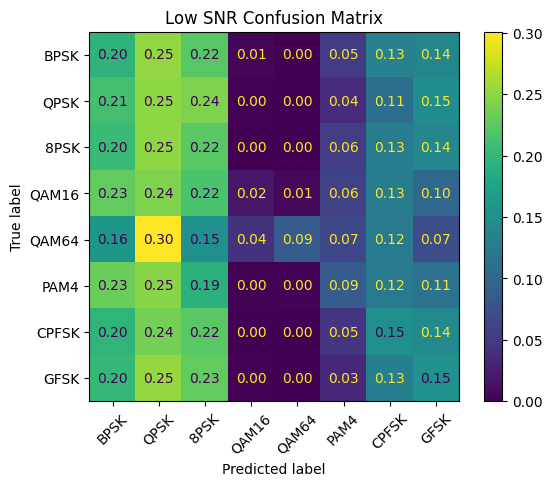

Medium SNR Accuracy: 55.27%


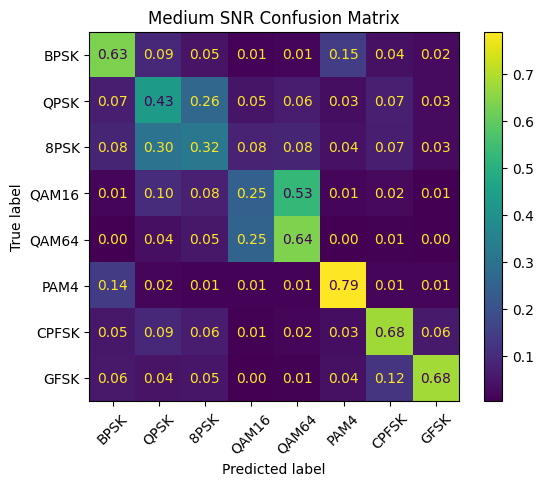

High SNR Accuracy: 80.16%


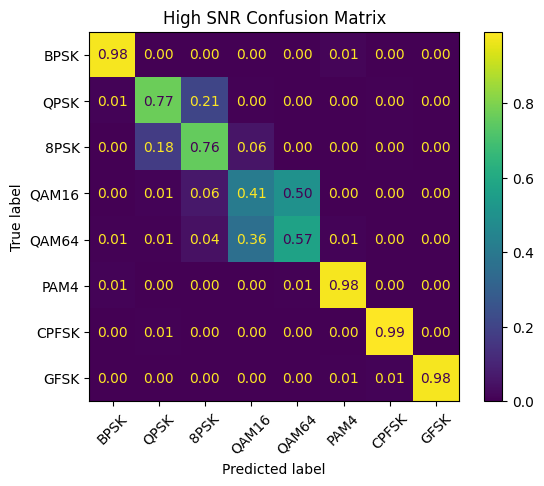

In [ ]:
for snr_group, snr_list in snr_ranges.items():
    acc_snr, cm_snr, (labels_snr, preds_snr) = evaluate_snr_model(fusion_model, X_test, Y_test, snrs_test, snr_list)
    if acc_snr is None:
        print(f"No samples for {snr_group} SNR range.")
        continue
    print(f"{snr_group} SNR Accuracy: {acc_snr*100:.2f}%")

    cm_norm_snr = cm_snr.astype(float)/cm_snr.sum(axis=1, keepdims=True)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_snr, display_labels=digital_mods)
    disp.plot(xticks_rotation=45, values_format=".2f")
    plt.title(f"{snr_group} SNR Confusion Matrix")
    plt.show()